In [6]:
import pandas as pd
import pickle
import numpy as np
from time import time
from operator import itemgetter
from scipy.stats import randint as sp_randint

from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import StratifiedKFold
from sklearn import datasets
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report

from patsy import dmatrices

%matplotlib inline


### Loading Datafame created in Police Shootings- Cleaning Data Notebook

In [3]:
df_dsmpl = pickle.load(open('df_dsmpl_orginal_charged_50.p', 'rb'))

### Random Forest Grid Search

In [4]:
y,X=dmatrices('charged_bool ~ manner_of_death + armed + age + gender + race +\
                city + state + signs_of_mental_illness + threat_level + flee + body_camera',
                data = df_dsmpl, return_type='dataframe')


# Split the dataset in four equal parts
X_train, X_test, y_train, y_test = train_test_split(
    X, np.ravel(y), test_size=0.25, random_state=0)


# build a classifier
clf = RandomForestClassifier(n_estimators=20)


# Utility function to report best scores
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")


# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(1, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 20

random_search = RandomizedSearchCV(clf, param_distributions=param_dist, scoring = 'recall',
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X, np.ravel(y))
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.grid_scores_)

# use a full grid over all parameters
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [1, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid, scoring= 'recall', cv =StratifiedKFold(np.ravel(y), n_folds=4))
start = time()
grid_search.fit(X, np.ravel(y))

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.grid_scores_)))
report(grid_search.grid_scores_)

RandomizedSearchCV took 2.56 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.388 (std: 0.196)
Parameters: {'bootstrap': True, 'min_samples_split': 6, 'max_depth': None, 'max_features': 10, 'min_samples_leaf': 1, 'criterion': 'entropy'}

Model with rank: 2
Mean validation score: 0.084 (std: 0.118)
Parameters: {'bootstrap': False, 'min_samples_split': 10, 'max_depth': None, 'max_features': 8, 'min_samples_leaf': 2, 'criterion': 'entropy'}

Model with rank: 3
Mean validation score: 0.000 (std: 0.000)
Parameters: {'bootstrap': False, 'min_samples_split': 5, 'max_depth': 3, 'max_features': 7, 'min_samples_leaf': 4, 'criterion': 'entropy'}

GridSearchCV took 35.26 seconds for 216 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.541 (std: 0.138)
Parameters: {'bootstrap': True, 'min_samples_split': 1, 'max_depth': None, 'max_features': 1, 'min_samples_leaf': 1, 'criterion': 'gini'}

Model with rank: 2
Mean validation score: 0.5

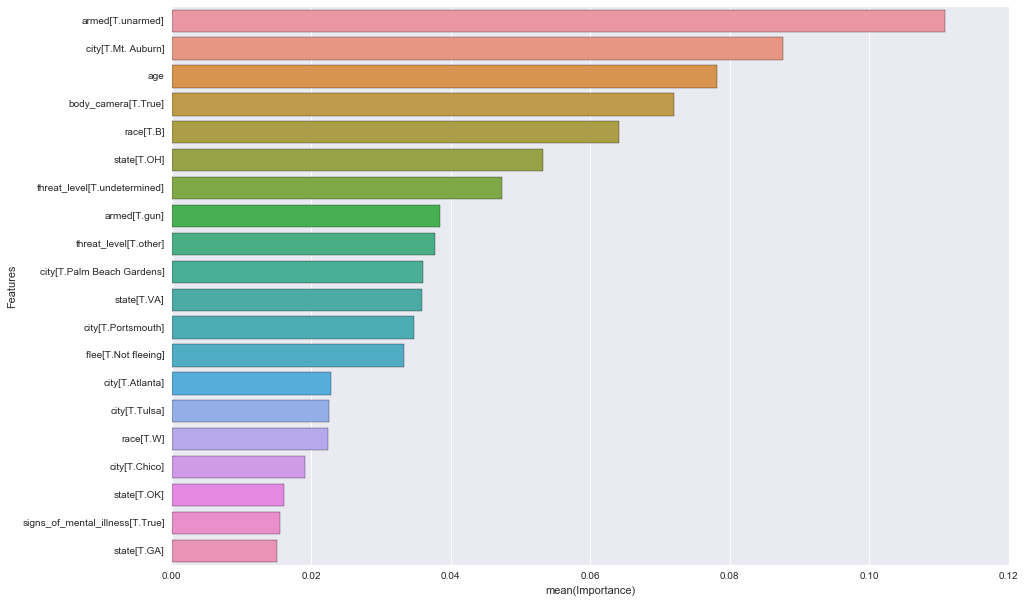

In [7]:
import seaborn as sns



clf = RandomForestClassifier(n_estimators=100, criterion='entropy',\
                             max_depth=None, bootstrap=True, min_samples_split=1, 
                             oob_score=True, min_samples_leaf=1)
clf = clf.fit(X, np.ravel(y))
clf.score(X, np.ravel(y))


features = X.columns
feature_importance = clf.feature_importances_
importance_df = pd.DataFrame({'Features': features, 'Importance': feature_importance})
importance_df.sort_values('Importance', inplace = True, ascending = False)

importance_df.sort_values

# Plotting the Graph
g = sns.barplot(x = "Importance", y = "Features", data = importance_df.head(20), orient = "h")
g.figure.set_size_inches(15,10)